<a href="https://colab.research.google.com/github/dhrubo404/vcg_weekly_reports/blob/main/week1_vcg_auction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simulation of a single sealed-bid auction that:


*   Runs in continuous time
*   Bidders arrive randomly before a fixed close time
*   Each bidder draws a private value $v_i$ and submits a bid to b_i.
*   At clase the auctioneer allocated to the highest bid and charges the second highest bid



In [ ]:
!pip install simpy
import simpy
import random
from dataclasses import dataclass
from typing import List, Dict, Optional, Callable



*   random for bidder values/arrivals
*   dataclass makes bid objects explicit



In [ ]:
@dataclass(frozen=True)
class Bid:
  bidder_id: int
  value: float
  bid: float
  time: float

Keeping 4 essential fields: id, true value, submitted bid, time it arrived

In [ ]:
class Auctioneer:
  """
  Simulation of a single item vcg auction
  """
  def __init__(self,env: simpy.Environment,close_time:float):
    self.env = env #simpy clock
    self.close_time = close_time #auction closing time
    self.bids: List[Bid] = [] #for holding all bid objects
    self.result: Optional[Dict] = None #filled after auction closes

  def submit_bid(self, bid: Bid):
    # Collection of bids
    self.bids.append(bid)

  def run(self):
    #Auctioneer waiting until closing time
    yield self.env.timeout(self.close_time)

    #If no bid, no allocation
    if len(self.bids) == 0:
      self.result = {
          "time": self.env.now,
          "winner": None,
          "payment": 0.0,
          "welfare": 0.0,
          "num_bids": 0
      }
      return
    #Sorting bids by submitted amount in descending manner
    sorted_bids = sorted(self.bids, key=lambda x: x.bid, reverse = True)
    winner = sorted_bids[0]
    second_price = sorted_bids[1].bid if len(sorted_bids)>=2 else 0.0
    payment = second_price
    welfare = winner.value
    revenue = payment
    utility = winner.value - payment
    self.result = {
            "time": self.env.now,
            "winner": winner.bidder_id,
            "winner_value": winner.value,
            "winner_bid": winner.bid,
            "payment": payment,
            "utility": utility,
            "revenue": revenue,
            "welfare": welfare,
            "num_bids": len(self.bids)
        }

The run() function is a SimPy generator. It yields until t = T then executes:
*    Step 1: Handling No bids. |B| = 0 , no allocation,payment,welfare
*    Step 2: Sort bids descending
*    Step 3: Identify winner and payment
*    Step 4: Computes outcomes: welfare, revenure, utility

In [ ]:
def bidder(env: simpy.Environment,
           bidder_id: int,
           auctioneer: Auctioneer,
           arrival_time: float,
           value_sampler: Callable[[], float],
           bidding_policy: Callable[[float], float]):
    """
    Each bidder is a process:
    * wait until arrival_time
    * sample private value v_i
    * compute bid b_i from bidding_policy(v_i)
    * submit bid to auctioneer
    """
    # Wait until the bidder "arrives" to the market
    yield env.timeout(arrival_time)

    # Sample the bidder's private value
    v = value_sampler()

    # Decide what to bid (truthful for VCG baseline)
    b = bidding_policy(v)

    # Submit to auctioneer
    auctioneer.submit_bid(Bid(
        bidder_id=bidder_id,
        value=v,
        bid=b,
        time=env.now
    ))

Mathematically:
$$t_i ∼ U[0,T],\ v_i ∼ U[0,1]\\b_i = f(v_i)$$ where f is the bidding policy

In [ ]:
def run_one_auction(num_bidders: int = 10,
                    close_time: float = 5.0,
                    seed: int = 0,
                    arrival_sampler: Optional[Callable[[], float]] = None,
                    value_sampler: Optional[Callable[[], float]] = None,
                    bidding_policy: Optional[Callable[[float], float]] = None) -> Dict:
    """
    Run a single auction and return full auction data:
    - all bids
    - ranking
    - winner
    - payments
    - utilities for all bidders
    """

    random.seed(seed)
    env = simpy.Environment()

    if arrival_sampler is None:
        arrival_sampler = lambda: random.uniform(0.0, close_time)

    if value_sampler is None:
        value_sampler = lambda: random.uniform(0.0, 1.0)

    if bidding_policy is None:
        bidding_policy = lambda v: v  # truthful default

    auctioneer = Auctioneer(env, close_time=close_time)
    env.process(auctioneer.run())

    for i in range(num_bidders):
        t_arr = arrival_sampler()
        env.process(bidder(env, i, auctioneer, t_arr, value_sampler, bidding_policy))

    env.run(until=close_time + 1e-6)

    # Post-processing for logging

    all_bids = auctioneer.bids

    # Sort bids descending by bid
    ranked_bids = sorted(all_bids, key=lambda x: x.bid, reverse=True)

    # Determine winner and payment
    if len(ranked_bids) > 0:
        winner = ranked_bids[0]
        second_price = ranked_bids[1].bid if len(ranked_bids) >= 2 else 0.0
    else:
        winner = None
        second_price = 0.0

    # Compute utilities for all bidders
    utilities = {}
    for bid in ranked_bids:
        if winner is not None and bid.bidder_id == winner.bidder_id:
            utilities[bid.bidder_id] = bid.value - second_price
        else:
            utilities[bid.bidder_id] = 0.0

    return {
        "time": env.now,
        "num_bidders": num_bidders,
        "all_bids": [
            {
                "bidder_id": b.bidder_id,
                "value": b.value,
                "bid": b.bid,
                "arrival_time": b.time
            } for b in all_bids
        ],
        "ranked_bids": [
            {
                "rank": i+1,
                "bidder_id": b.bidder_id,
                "value": b.value,
                "bid": b.bid
            } for i, b in enumerate(ranked_bids)
        ],
        "winner": winner.bidder_id if winner else None,
        "payment": second_price,
        "utilities": utilities
    }

Set up and run a full simulation of a single auction step by step.

Default Parameters:
$$t_i ∼ U[0,T],\ v_i ∼ U[0,1], b_i = v_i$$

Register auctioneer.run() as a process which fires at t = T
Register n bidder processes each firing at their own t_i
env.run runs the clock forward, triggering all events.

Post processing:

Resorting of bids
Determining bid winner
Computation of per bidder utilities where $u_i = v_i^*-b_2\ if\ i=i^* \ else\ 0$
Returns a dictionary with: all raw bids,ranked bids, winner ID, payment  = $b_2$ and all utilities

In [ ]:
result = run_one_auction()

print("Winner:", result["winner"])
print("Payment:", result["payment"])
print("\nAll Bids:")
for b in result["ranked_bids"]:
    print(b)

Winner: 1
Payment: 0.9097462559682401

All Bids:
{'rank': 1, 'bidder_id': 1, 'value': 0.9827854760376531, 'bid': 0.9827854760376531}
{'rank': 2, 'bidder_id': 9, 'value': 0.9097462559682401, 'bid': 0.9097462559682401}
{'rank': 3, 'bidder_id': 3, 'value': 0.9081128851953352, 'bid': 0.9081128851953352}
{'rank': 4, 'bidder_id': 0, 'value': 0.9021659504395827, 'bid': 0.9021659504395827}
{'rank': 5, 'bidder_id': 6, 'value': 0.8102172359965896, 'bid': 0.8102172359965896}
{'rank': 6, 'bidder_id': 2, 'value': 0.7558042041572239, 'bid': 0.7558042041572239}
{'rank': 7, 'bidder_id': 8, 'value': 0.6183689966753316, 'bid': 0.6183689966753316}
{'rank': 8, 'bidder_id': 7, 'value': 0.5046868558173903, 'bid': 0.5046868558173903}
{'rank': 9, 'bidder_id': 5, 'value': 0.28183784439970383, 'bid': 0.28183784439970383}
{'rank': 10, 'bidder_id': 4, 'value': 0.25050634136244054, 'bid': 0.25050634136244054}


Run one auction with default settings

In [ ]:
def run_many(num_trials: int = 1000,
             num_bidders: int = 10,
             close_time: float = 5.0,
             bidding_policy=None) -> Dict:

    results = []
    for k in range(num_trials):
        res = run_one_auction(
            num_bidders=num_bidders,
            close_time=close_time,
            seed=k,
            bidding_policy=bidding_policy
        )
        results.append(res)

    # Revenue = payment
    avg_revenue = sum(r["payment"] for r in results) / num_trials

    # Welfare = winner's true value
    avg_welfare = 0.0
    for r in results:
        if r["winner"] is not None:
            winner_id = r["winner"]
            winner_value = next(
                b["value"] for b in r["ranked_bids"]
                if b["bidder_id"] == winner_id
            )
            avg_welfare += winner_value

    avg_welfare /= num_trials

    # Winner utility
    avg_utility = 0.0
    for r in results:
        if r["winner"] is not None:
            avg_utility += r["utilities"][r["winner"]]

    avg_utility /= num_trials

    return {
        "num_trials": num_trials,
        "num_bidders": num_bidders,
        "avg_revenue": avg_revenue,
        "avg_welfare": avg_welfare,
        "avg_winner_utility": avg_utility
    }

Running K independent auctions and computing aggregate statistics.

Average revenue : $$\bar{R} = \frac{1}{K}\sum_{k=1}^Kp^{(k)}=\frac{1}{K}\sum_{k=1}^Kb^{(k)}_2$$

Average Welfare: $$\bar{W} = \frac{1}{K}\sum_{k=1}^Kv_{i*^{(k)}}$$

Measures whether the item consistently goes to the highest-value bidder. Under truthful bidding, $\bar{W}$ equals $\mathbb{E}[max(v_1,....,v_n)]$

Average Winner Utility:$$\bar{u} = \frac{1}{K}\sum_{k=1}^K(v_i*^{(k)}-p^{(k)})$$

These satisfy the identity at every trial: $v_{i*} = p +u_{i*}$ so $\bar{W} = \bar{R} +\bar{u}$

In [ ]:
truthful_stats = run_many(
    num_trials=2000,
    num_bidders=10,
    close_time=5.0,
    bidding_policy=lambda v: v
)

shaded_stats = run_many(
    num_trials=2000,
    num_bidders=10,
    close_time=5.0,
    bidding_policy=lambda v: 0.8 * v
)

truthful_stats, shaded_stats

({'num_trials': 2000,
  'num_bidders': 10,
  'avg_revenue': 0.816305681041638,
  'avg_welfare': 0.9075699555139084,
  'avg_winner_utility': 0.09126427447227081},
 {'num_trials': 2000,
  'num_bidders': 10,
  'avg_revenue': 0.6530445448333105,
  'avg_welfare': 0.9075699555139084,
  'avg_winner_utility': 0.25452541068059814})

Running K = 2000 trials under 2 policies:
*  Truthful ($b_i = v_i$)
*  Shaded ($b_i = 0.8v_i$)

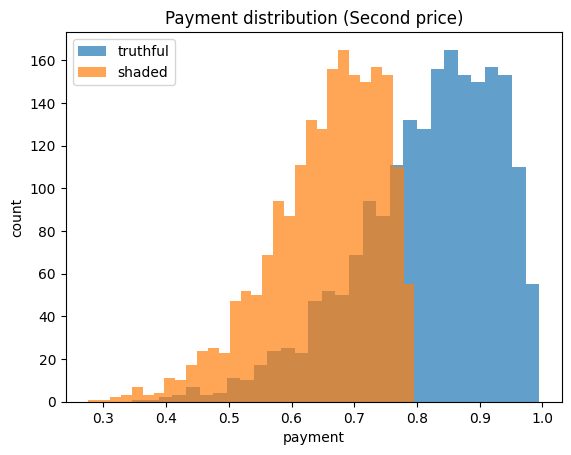

In [ ]:
import matplotlib.pyplot as plt

def collect_payments(num_trials: int = 2000,
                     num_bidders: int = 10,
                     close_time: float = 5.0,
                     bidding_policy: Optional[Callable[[float], float]] = None):
    pays = []
    for k in range(num_trials):
        res = run_one_auction(
            num_bidders=num_bidders,
            close_time=close_time,
            seed=k,
            bidding_policy=bidding_policy
        )
        pays.append(res["payment"])
    return pays

payments_truth = collect_payments(bidding_policy=lambda v: v)
payments_shade = collect_payments(bidding_policy=lambda v: 0.8 * v)

plt.hist(payments_truth, bins=30, alpha=0.7, label="truthful")
plt.hist(payments_shade, bins=30, alpha=0.7, label="shaded")
plt.legend()
plt.title("Payment distribution (Second price)")
plt.xlabel("payment")
plt.ylabel("count")
plt.show()

Plotting overlapping histograms